In [1]:
import numpy as np
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from dinov2_feature_extraction import load_model, get_dense_descriptor

from skimage import io
import matplotlib.pyplot as plt


In [2]:
dinov2_sizes = {"small": 384,
                "base": 768,
                "large": 1024,
                "giant": 1536} # tamaños del feature vector de cada version de dinov2

backbone_size = 'small'
model = load_model(backbone_size)

Using cache found in /home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
from decimal import Decimal, getcontext
from dinov2_feature_extraction import min_max_scale
import os
import torch
import numpy as np
from tqdm import tqdm
from skimage import io
from skimage.transform import resize
from skimage import morphology
from skimage import measure
from skimage.filters import threshold_otsu
from sklearn.decomposition import PCA

from skimage import morphology, measure

def pca_colorize_2(features, output_shape):
    # Aplicar PCA como antes
    inverted = False
    remove = True
    pca = PCA(n_components=3)
    pca.fit(features)
    rgb = pca.transform(features)
    rgb = min_max_scale(rgb)
    rgb = rgb.reshape(output_shape + (3,))

    # Set the precision you need
    getcontext().prec = 10

    mean_color = np.mean(rgb, axis=(0, 1))
    print(mean_color)
    dominant_color = np.argmax(mean_color)
    print(dominant_color)
    # Convert numpy.float32 to native Python float, then to Decimal
    mean_color_0 = Decimal(float(mean_color[0]))
    mean_color_2 = Decimal(float(mean_color[2]))

    # Calculate the difference using Decimal
    diff =  mean_color_2-mean_color_0

    # Calculate the difference using Decimal
    diff_2 =  mean_color_0 - mean_color_2

    # Aplicar umbral de Otsu al color dominante
    thresh = threshold_otsu(rgb[:, :, 0])
    rgb_mask = (rgb[:, :, 0] > thresh)*1
    # Invertir la máscara si el color dominante no es el primero
    if dominant_color == 2 and diff > Decimal('1.8e-7'):
        print("invertir")
        inverted = True
        rgb_mask = 1 - rgb_mask

    elif dominant_color == 2 and diff <= Decimal('1.8e-7'):
        remove = False

    if dominant_color == 0 and diff_2 <= Decimal('9e-8'):
        remove = False
    rgb[:, :, 0] *= rgb_mask
    rgb[:, :, 1] *= rgb_mask
    rgb[:, :, 2] *= rgb_mask
    rgb = min_max_scale(rgb)

    return rgb, inverted, remove



def foreground_mask_2(attention_rgb, inverted, remove, use_bbox=True):
    # Crear la máscara básica
    attention_mask = attention_rgb.mean(axis=-1) > 0
    attention_mask = morphology.binary_dilation(attention_mask)
    if remove == False:
        print("no remove")
        # Crear una matriz de unos con las mismas dimensiones que attention_mask
        return np.ones_like(attention_mask)
    if use_bbox:
        attention_labeled = measure.label(attention_mask)
        regions = measure.regionprops(attention_labeled)
        '''
        if inverted:
            # Crear una máscara invertida donde se mantenga todo excepto las bounding boxes
            inverted_mask = np.ones_like(attention_mask, dtype=bool)
            for props in regions:
                ymin, xmin, ymax, xmax = props.bbox
                inverted_mask[ymin:ymax, xmin:xmax] = False
            return inverted_mask
        
        else:
        '''
        # Proceso normal: expandir la máscara dentro de los bounding boxes
        for props in regions:
            ymin, xmin, ymax, xmax = props.bbox
            attention_mask[ymin:ymax, xmin:xmax] = True
    
    return attention_mask

In [8]:
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page1.jpg'  
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page4.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page40.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page114.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page104.jpg'   
dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page1.jpg'  


[0.45777822 0.457778   0.4577784 ]
2


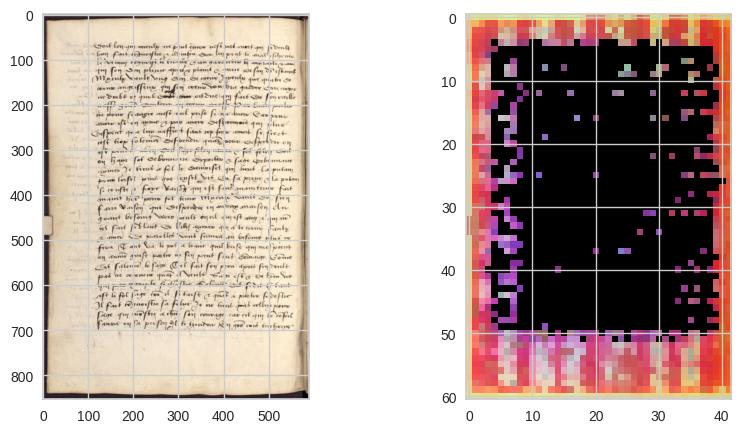

'\ntest_mask_box_2 = foreground_mask_2(test, inverted, remove, use_bbox=True)\nio.imshow(test_mask_box_2)\nio.show()\n'

In [9]:
new_img = io.imread(dataset_path_new_img_1)


new_image_features, new_image_attention, new_image_grid_shape = get_dense_descriptor(model, new_img)

#io.imshow(new_img)
#io.show()

test, inverted, remove = pca_colorize_2(new_image_attention, new_image_grid_shape)
#io.imshow(test)
#io.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) 
axes[0].imshow(new_img) 
axes[1].imshow(test) 

plt.show() 

'''
test_mask = foreground_mask(test, use_bbox=False)
io.imshow(test_mask)
io.show()

test_mask_box = foreground_mask(test, use_bbox=True)
io.imshow(test_mask_box)
io.show()
'''
'''
test_mask_box_2 = foreground_mask_2(test, inverted, remove, use_bbox=True)
io.imshow(test_mask_box_2)
io.show()
'''



In [6]:
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image

def pca_component_images(features, output_shape):
    # Aplicar PCA para obtener 3 componentes principales
    pca = PCA(n_components=3)
    pca_components = pca.fit_transform(features)

    # Función para escalar y convertir un componente en una imagen
    def component_to_image(component):
        component_scaled = (component - np.min(component)) / (np.max(component) - np.min(component))
        component_scaled = (component_scaled * 255).astype(np.uint8)
        return Image.fromarray(component_scaled.reshape(output_shape))

    # Convertir cada componente en una imagen
    image1 = component_to_image(pca_components[:, 0])
    image2 = component_to_image(pca_components[:, 1])
    image3 = component_to_image(pca_components[:, 2])

    return image1, image2, image3


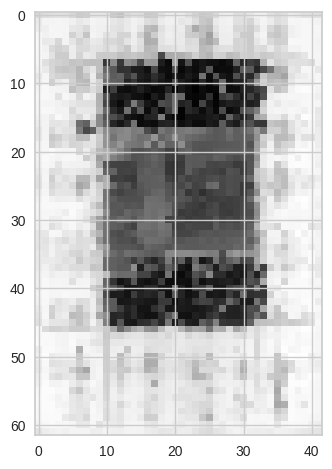

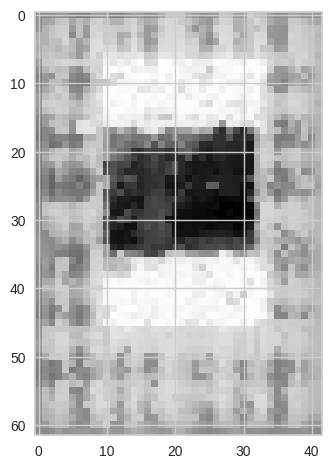

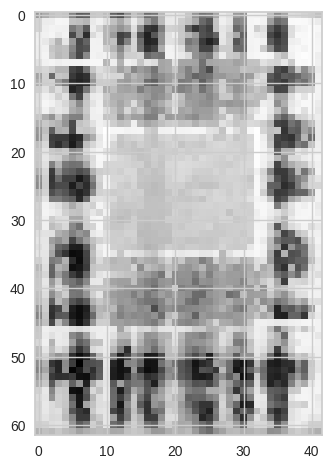

In [7]:
test1, test2, test3 = pca_component_images(new_image_attention, new_image_grid_shape)
test1_array = np.array(test1)
test2_array = np.array(test2)
test3_array = np.array(test3)

# Ahora puedes utilizar plt.imshow para mostrar las imágenes
plt.imshow(test1_array)
plt.show()
plt.imshow(test2_array)
plt.show()
plt.imshow(test3_array)
plt.show()